<a href="https://colab.research.google.com/github/xelothi/LDA_practice/blob/main/clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install --upgrade ipykernel

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import string
from nltk.corpus import stopwords
import re
import nltk
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
import matplotlib.cm as cm

In [ ]:
df = pd.read_csv("train.csv", index_col=[0], on_bad_lines="skip")
df.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


Text(0.5, 1.0, 'Number of entries per discipline')

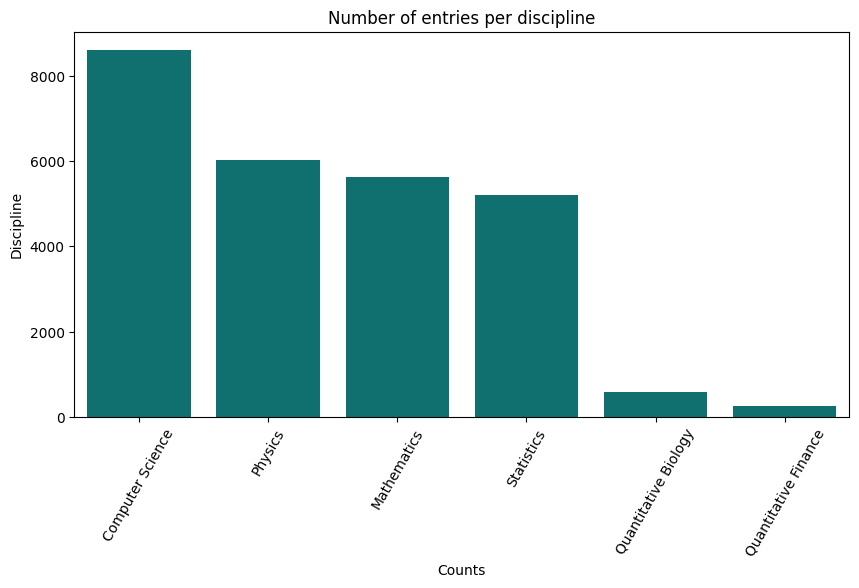

In [ ]:
fields = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]
counts = df[fields].sum()
plt.figure(figsize=(10,5))
ax = sns.barplot(x=counts.index, y=counts.values, color="teal")
plt.xticks(rotation=60)
ax.set_xlabel("Counts")
ax.set_ylabel("Discipline")
ax.set_title("Number of entries per discipline")

In [ ]:
df["Text"] = df["TITLE"] + ":" + df["ABSTRACT"]
df = df.drop(columns=["Quantitative Biology", "Quantitative Finance"], axis=1)
df.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Text
ID,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,Reconstructing Subject-Specific Effect Maps: ...
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,Rotation Invariance Neural Network: Rotation ...
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,Spherical polyharmonics and Poisson kernels fo...
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,A finite element approximation for the stochas...
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,Comparative study of Discrete Wavelet Transfor...


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
def preprocessing(data):
  #remove \n
  final = re.sub(r"\n", " ", data)
  #removes all digits
  final = re.sub(r"[\d]", " ", data)
  #removes special characters
  final = re.sub("-", " ", data)
  final = re.sub("[^\w ]+", " ", data)
  final = str(final)
  #removes punctuation
  final = final.translate(str.maketrans("", "", string.punctuation))
  # lemmatization
  lemmatizer = WordNetLemmatizer()
  final = ' '.join(lemmatizer.lemmatize(word) for word in final.split())
  return final

In [ ]:
df["Text"] = df["Text"].apply(lambda x: preprocessing(x))
df.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Text
ID,,,,,,,
1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,Reconstructing Subject Specific Effect Maps Pr...
2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,Rotation Invariance Neural Network Rotation in...
3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,Spherical polyharmonics and Poisson kernel for...
4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,A finite element approximation for the stochas...
5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,Comparative study of Discrete Wavelet Transfor...


In [ ]:
tfidf = TfidfVectorizer(lowercase=True, max_df=0.8, min_df=5, ngram_range=(1,4), stop_words="english",max_features=4000)
tfidf_dtm = tfidf.fit_transform(df["Text"])
tfidf_dtm_arr = tfidf_dtm.toarray()
tfidf_dtm.shape

(20972, 4000)

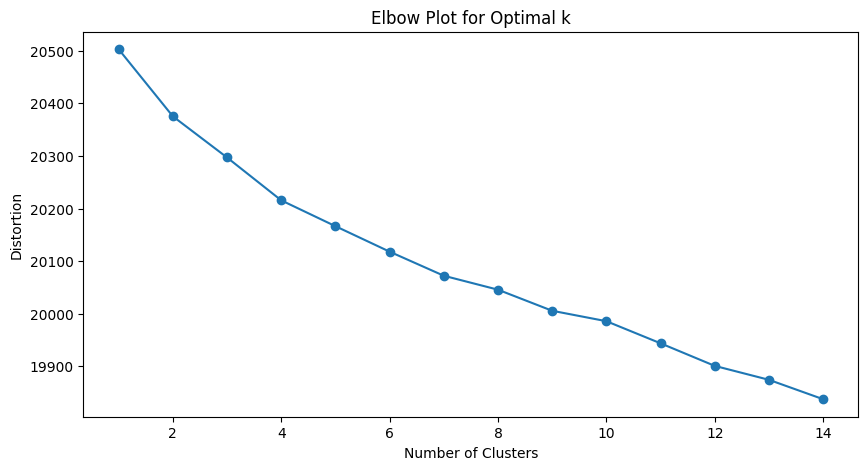

In [ ]:
def elbow_plot(data, num_k):
 inertion = []
 for k in range(1, num_k):
    model = KMeans(n_clusters=k, init="k-means++", max_iter=100, n_init=1, random_state=42)
    model.fit(data)
    inertion.append(model.inertia_)

 plt.figure(figsize=(10,5))
 plt.plot(range(1,num_k), inertion, marker='o')
 plt.xlabel('Number of Clusters')
 plt.ylabel('Distortion')
 plt.title('Elbow Plot for Optimal k')

elbow_plot(tfidf_dtm, 15)

In [ ]:
model = KMeans(n_clusters=11, random_state=42, init="k-means++", n_init=1)
clusters = model.fit_predict(tfidf_dtm)

In [ ]:
def pca_tsne(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=2000, replace=False)

    pca = PCA(n_components=2)
    p = pca.fit_transform(data[max_items,:])

    tsne = TSNE()
    t = tsne.fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    idx = np.random.choice(range(p.shape[0]), size=100, replace=False)
    f, ax = plt.subplots(1, 2, figsize=(14, 6))

    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    ax[0].scatter(p[idx, 0], p[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')

    ax[1].scatter(t[idx, 0], t[idx, 1], c=label_subset)
    ax[1].set_title('t-SNE Cluster Plot')


    plt.show()

    return p, t

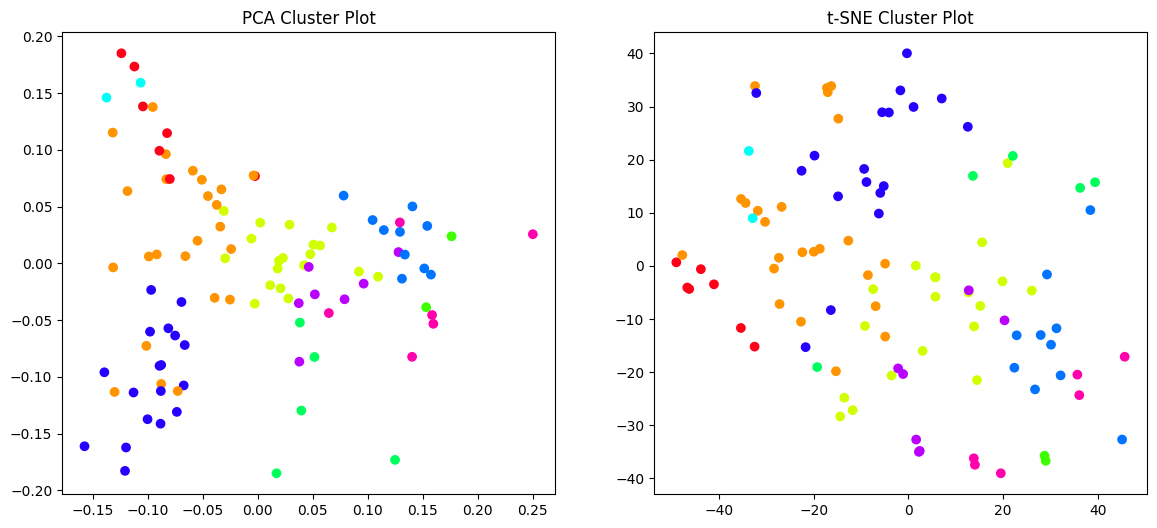

(array([[ 0.03953458, -0.1296591 ],
        [ 0.04181054,  0.00832491],
        [-0.03747608, -0.10198032],
        ...,
        [-0.07836144,  0.05875463],
        [-0.08659896,  0.05891661],
        [ 0.1853563 ,  0.04425125]]),
 array([[-19.258732  , -19.062614  ],
        [ -9.872635  , -33.03347   ],
        [ 35.880398  ,  13.465489  ],
        ...,
        [-25.400427  ,   4.2935314 ],
        [-26.71972   ,  -0.25579926],
        [ 30.844065  , -26.074593  ]], dtype=float32))

In [ ]:
pca_tsne(tfidf_dtm_arr, clusters)

In [ ]:
def get_top_keywords(data, cluster, labels, n):
  df = pd.DataFrame(data).groupby(cluster).mean()

  for i,j in df.iterrows():
    print(f"Cluster {i}")
    print(",".join([labels[k] for k in np.argsort(j)[-n:]]))

In [ ]:
get_top_keywords(tfidf_dtm_arr, clusters, tfidf.get_feature_names_out(), 10)

Cluster 0
twitter,social network,social medium,data,online,information,content,network,social,user
Cluster 1
state,particle,time,field,model,quantum,wave,solution,energy,equation
Cluster 2
control,using,analysis,paper,approach,method,time,based,model,data
Cluster 3
human,action,environment,task,reinforcement learning,reinforcement,policy,learning,agent,robot
Cluster 4
optimal,stochastic,matrix,time,convex,method,optimization,problem,algorithm,graph
Cluster 5
topological,quantum,magnetic field,transition,state,temperature,field,phase,magnetic,spin
Cluster 6
classification,feature,machine,method,training,deep,model,data,image,learning
Cluster 7
operator,manifold,theorem,mathcal,prove,function,space,algebra,mathbb,group
Cluster 8
bayesian,regression,parameter,inference,method,estimation,data,estimator,distribution,model
Cluster 9
networks,method,convolutional,training,learning,model,deep,neural network,neural,network
Cluster 10
dark matter,ray,emission,cluster,dark,stellar,planet,mass,gal

In [ ]:
lda = LatentDirichletAllocation(random_state=42, n_components=4)
lda_results = lda.fit_transform(tfidf_dtm)
lda_topics = np.argmax(lda_results,axis=1)

<Axes: >

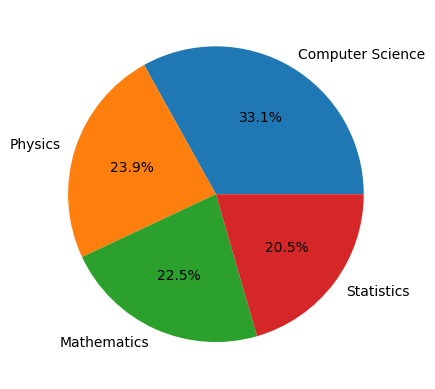

In [ ]:
df.loc[np.where(lda_topics == 2)[0].tolist(),['Computer Science', 'Physics', 'Mathematics', 'Statistics']].sum(axis = 0).plot(kind = 'pie', autopct='%1.1f%%')

In [ ]:
test = pd.read_csv("test.csv")
test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [ ]:
test["Text"] = test["TITLE"] + ":" + test["ABSTRACT"]
test.head()

,ID,TITLE,ABSTRACT,Text
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...,Closed-form Marginal Likelihood in Gamma-Poiss...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...,Laboratory mid-IR spectra of equilibrated and ...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...,Case For Static AMSDU Aggregation in WLANs: F...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...,The $Gaia$-ESO Survey: the inner disk intermed...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...,Witness-Functions versus Interpretation-Functi...


In [ ]:
test["Text"] = test["Text"].apply(lambda x: preprocessing(x))

In [ ]:
test_dtm = tfidf.transform(test["Text"])
test_topics = lda.transform(test_dtm)
max_indices = np.argmax(test_topics,axis=1)

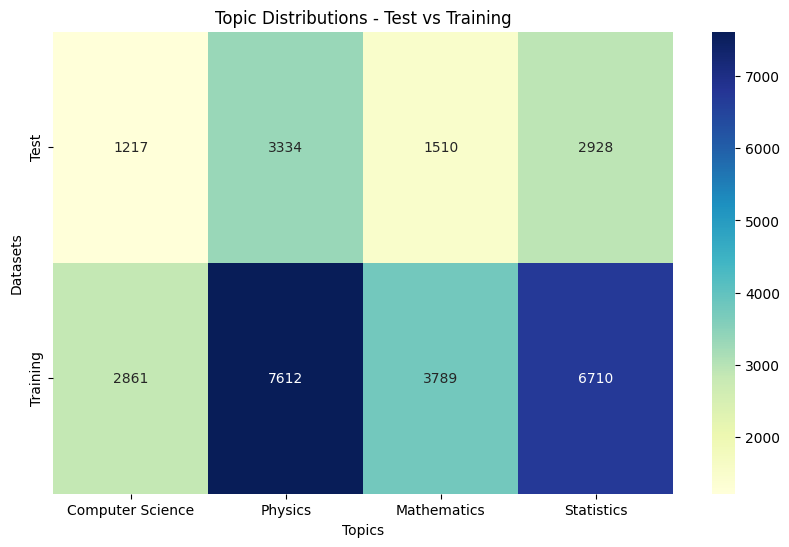

In [ ]:
# Calculate the topic distributions
test_topic_counts = np.bincount(max_indices)
training_topic_counts = np.bincount(lda_topics)

# Combine the topic counts for plotting
combined_topic_counts = np.vstack((test_topic_counts, training_topic_counts))

# Define labels for the heatmap
topic_labels = ['Computer Science', 'Physics', 'Mathematics', 'Statistics']
dataset_labels = ['Test', 'Training']

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=combined_topic_counts, annot=True, fmt='d', cmap='YlGnBu', xticklabels=topic_labels, yticklabels=dataset_labels)
plt.title('Topic Distributions - Test vs Training')
plt.xlabel('Topics')
plt.ylabel('Datasets')
plt.show()